<a href="https://colab.research.google.com/github/ferreret/kaggle-competitions/blob/main/Titanic02_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Titanic - Machine Learning from Disaster</center>

**<center>Notebook 2: Random Forest</center>**

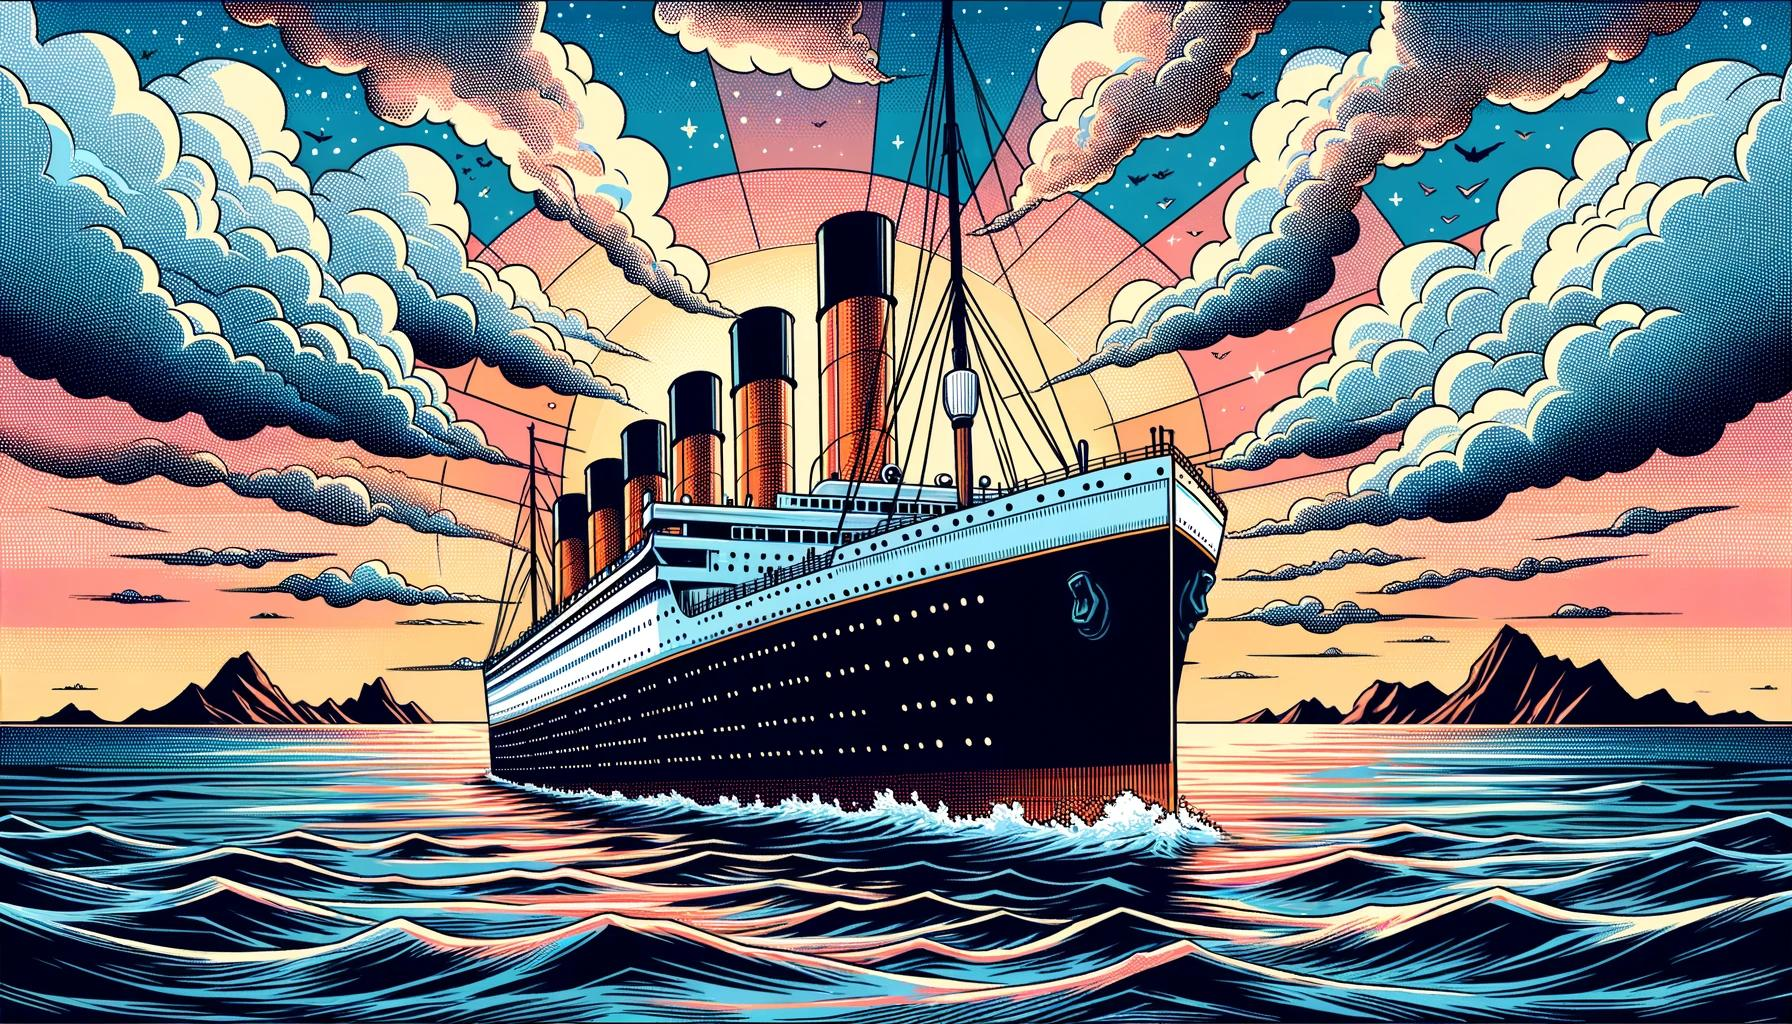

## Note

In this notebook, we will utilize a Random Forest Classifier to predict whether passengers survived or not.

To revisit the Exploratory Data Analysis (EDA) for this dataset, please refer to the notebook titled [Titanic01 - EDA + Logistic Regression](https://www.kaggle.com/code/nicolsbarcel/titanic01-eda-logistic-regression).

## Import libraries

In [6]:
!pip install --upgrade ipykernel

In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Show columns without truncate
pd.set_option('display.max_colwidth', None)
# Show all columns
pd.set_option('display.max_columns', None)


## Data Preprocessing

At this point, we're going to import the data and perform some basic preprocessing steps.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/Formació/Data Science + Machine Learning/Kaggle/data/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Let's separate the features from the target variable
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

X = train_df[features]
y = train_df['Survived']

### Handling missing values

In [11]:
missing_values_count = X.isnull().sum()
print(missing_values_count)

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64


Let's fill the missing values in the `Age` column with the mean age based on `Sex` and `Pclass`.

In [12]:
# Group by Sex and Pclass and calculate the mean of Age
mean_ages = X.groupby(['Sex', 'Pclass'])['Age'].mean()

# Define function to fill missing values for age
def fill_age(row):
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'], row['Pclass']]
    else:
        return row['Age']

X.loc[:, 'Age'] = X.apply(fill_age, axis=1)

/tmp/ipykernel_22640/846034387.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Age'] = X.apply(fill_age, axis=1)


In [13]:
# Check if there are still missing values
missing_values_count = X.isnull().sum()
print(missing_values_count)

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


Great, no missing values in the `Age` column anymore.

### Handling categorical variables

Let's convert the categorical variables into dummy/indicator variables.

In [14]:
X_encoded = pd.get_dummies(X, columns=['Sex', 'Pclass'], drop_first=True)
X_encoded.head()

,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,1,0,1
1,38.0,1,0,71.2833,0,0,0
2,26.0,0,0,7.9250,0,0,1
3,35.0,1,0,53.1000,0,0,0
4,35.0,0,0,8.0500,1,0,1


## Helper functions

In [15]:
def run_gridsearch(seed, params_grid):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=seed, stratify=y)

    # Create the classifier
    clf = RandomForestClassifier(random_state=seed)

    gs = GridSearchCV(clf, params_grid, cv=5, n_jobs=-1)

    # Fit the optimizer
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    result = {
        'seed': seed,
        'best_params': gs.best_params_,
        'best_score': gs.best_score_,
        'accuracy': accuracy
    }

    return result

In [16]:
def model_results(predicted, real):

    accuracy = accuracy_score(predicted, real)
    print(f'The accuracy score is: {accuracy * 100:.2f} %\n')

    print(classification_report(real, predicted))

    sns.heatmap(confusion_matrix(real, predicted), annot=True, fmt='g', cmap='Blues');
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();


In [17]:
def plot_ROC_AUC(model, X_train, X_test, y_train, y_test):
    # Get the probabilities of the positive class for training and testing data
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Calculate the ROC curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Set up the figure and axis for the plot, with a specified size
    plt.figure(figsize=(10, 7))

    # Plot the ROC curve for the training data
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')

    # Plot the ROC curve for the testing data
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

    # Plot a gray dashed line representing random guessing
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Set the limits of the x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Label the axes and the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Random Forest')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Add a grid to the plot
    plt.grid(True)

    # Display the plot
    plt.show();

## Modeling with Random Forest

Now, we're going to train a Random Forest Classifier to predict whether passengers survived or not.

We'll try different seeds and perform a Bayes search to find the best hyperparameters.

In [19]:
warnings.filterwarnings('ignore')

seeds = [0, 1, 42, 50, 123]

results = []

# Define the parameter grid
params_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': [2, 3, 4, 5],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

for seed in seeds:
    results.append(run_gridsearch(seed, params_grid))

warnings.resetwarnings()

In [20]:
results_df = pd.DataFrame(results)

results_df.sort_values(by='accuracy', ascending=False, inplace=True)

results_df

,seed,best_params,best_score,accuracy
0,0,"{'bootstrap': False, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}",0.839523,0.850746
3,50,"{'bootstrap': False, 'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}",0.842710,0.832090
4,123,"{'bootstrap': True, 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}",0.842735,0.824627
1,1,"{'bootstrap': False, 'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}",0.847535,0.805970
2,42,"{'bootstrap': False, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}",0.849084,0.783582


Let's try with `seed=0` and the parameters we've calculated

## Evaluating the model

In [21]:
best_seed = results_df.iloc[0]['seed']
best_params = results_df.iloc[0]['best_params']

# Let's split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=best_seed, stratify=y)

# Create the classifier
rf_clf = RandomForestClassifier(random_state=best_seed, **best_params)

# Fit the model
rf_clf.fit(X_train, y_train)


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=0)

Now, let's evaluate the model

The accuracy score is: 85.07 %

              precision    recall  f1-score   support

           0       0.85      0.93      0.88       165
           1       0.86      0.73      0.79       103

    accuracy                           0.85       268
   macro avg       0.85      0.83      0.84       268
weighted avg       0.85      0.85      0.85       268



<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


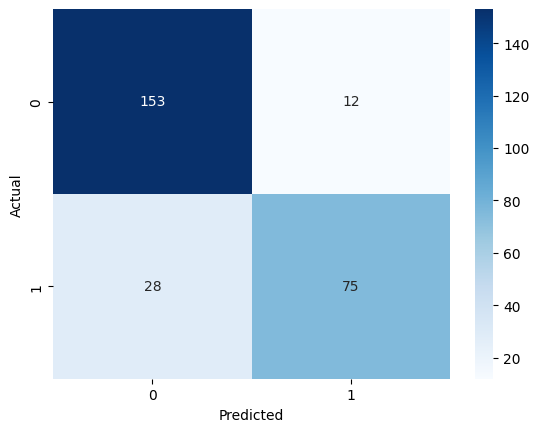

In [22]:
y_pred = rf_clf.predict(X_test)

model_results(y_pred, y_test)

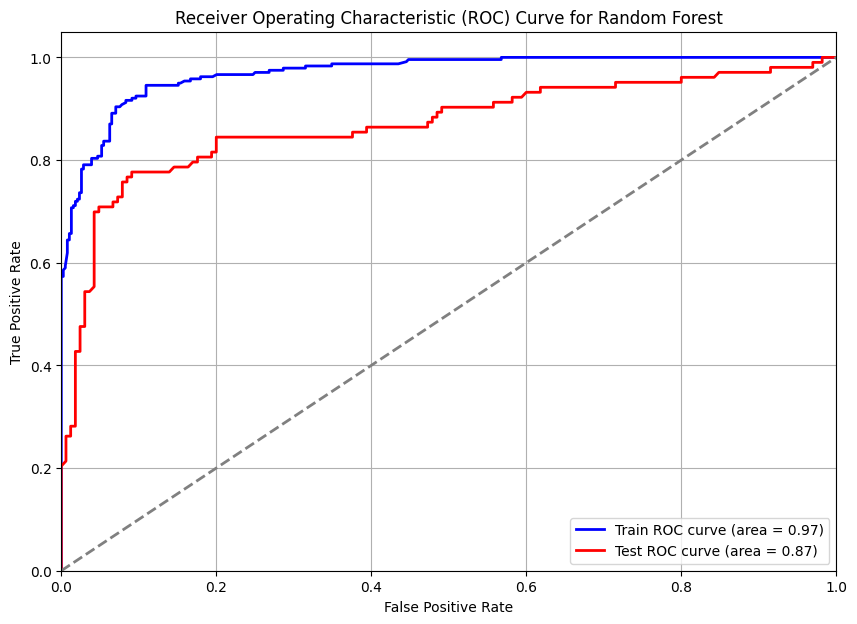

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [23]:
plot_ROC_AUC(rf_clf, X_train, X_test, y_train, y_test)

There is overfitting, let's improve the hyper-parameters

In [24]:
print(results_df.iloc[0]['best_params']);

{'bootstrap': False, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


We'll try with another gridsearch to avoid overfitting:

- Reducing max_depth: Lower values will simplify the model.
- Increasing min_samples_split: Requires more samples to create a new node.
- Increasing min_samples_leaf: Requires more samples at leaf level.

In [27]:
# Modified parameter grid
params_grid = {
    'n_estimators': [300, 400, 500],
    'max_features': [3, 4, 5],  # smaller max_features
    'max_depth': [2, 3, 4],  # reduced max_depth
    'min_samples_split': [10, 12, 14],  # increased min_samples_split
    'min_samples_leaf': [3, 4, 5],  # increased min_samples_leaf
    'bootstrap': [False]  # keep it False, as it was in the best params
}

result = run_gridsearch(seed=0, params_grid=params_grid)

# Get the best parameters
print(result)


{'seed': 0, 'best_params': {'bootstrap': False, 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}, 'best_score': 0.8154322580645162, 'accuracy': 0.8059701492537313}


The accuracy score is: 80.60 %

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       165
           1       0.86      0.59      0.70       103

    accuracy                           0.81       268
   macro avg       0.82      0.77      0.78       268
weighted avg       0.81      0.81      0.80       268



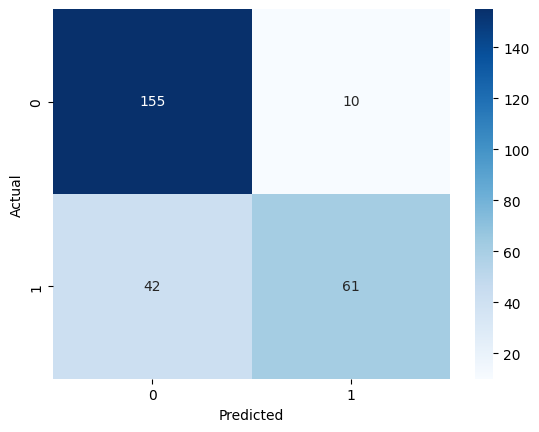

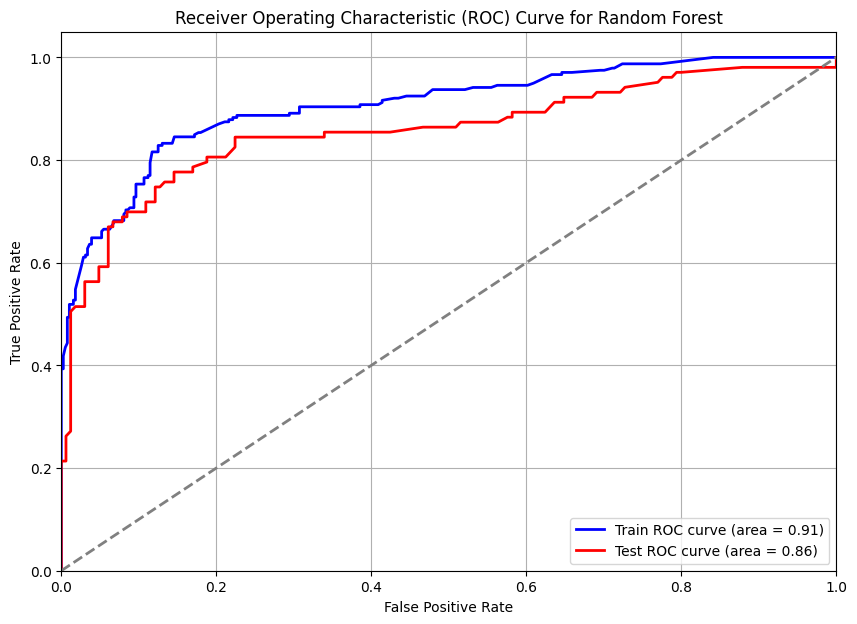

In [28]:
best_seed = result['seed']
best_params = result['best_params']

# Let's split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=best_seed, stratify=y)

# Create the classifier
rf_clf = RandomForestClassifier(random_state=best_seed, **best_params)

# Fit the model
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
model_results(y_pred, y_test)
plot_ROC_AUC(rf_clf, X_train, X_test, y_train, y_test)